# 04 Multiple Linear regression model 

> k-fold cross validation of regression model choice   

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

---

These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [6]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [7]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,Male_over_65,over_65,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,23644.9796,51920.6826,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,14170.0187,31637.7606,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,10171.4566,22570.0090,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,13527.6316,29465.7648,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,9396.6343,20046.6806,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507


This performs 5 fold cross-validation to determine the best combination of covariates. 

In [8]:
#|export 

# Potential covariates 
covar_opt = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,8):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [9]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc')

In [10]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7674882777954845",
 "Covariates:('over_65_pc', 'ALevel_plus_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7667498581680415",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7667010442466262",
 "Covariates:('over_65_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7664719739876984",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7664142681554167"]

In [11]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5', 'covariate 6', 'covariate 7']

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [12]:
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7
0,0.739684,over_65_pc,None,None,None,None,None,None
1,-0.003884,female_pc,None,None,None,None,None,None
2,0.110213,ALevel_plus_pc,None,None,None,None,None,None
3,0.552557,white_pc,None,None,None,None,None,None
4,0.641614,HYP_afflicted_pc,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
122,0.763680,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,None
123,0.763539,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,None
124,0.765706,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,None
125,0.744675,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,None


How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [13]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [14]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-60]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['South Bucks',
 'South Northamptonshire',
 'Chiltern',
 'Aylesbury Vale',
 'Wycombe']

2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

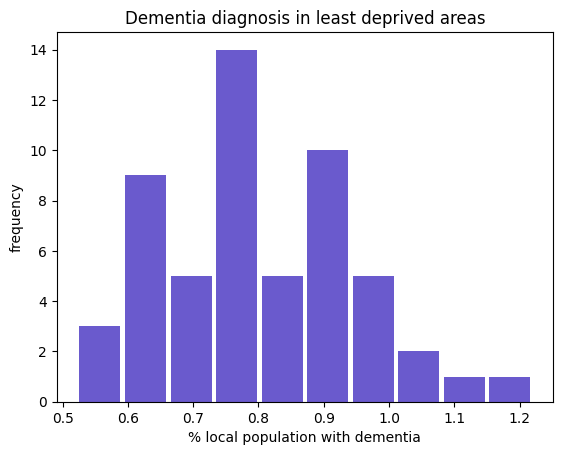

In [15]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = 100*df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

In [16]:
# Potential covariates 
covar_opt = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Outcome data 
Y_data = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 2
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,8):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_topIMD[list(subset)].values.reshape(-1,i)
        model.fit(X=X_data, y=Y_data)
        scores = model.score(X=X_data, y=Y_data)
        # evaluate the model using 5-fold CV 
        #scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [17]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.5483049320170065",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.5470352621819567",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.5463040349426899",
 "Covariates:('over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'STIA_afflicted_pc'), Accuracy:0.54607617552517",
 "Covariates:('over_65_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.5433163711792113"]

In [18]:
# Multiple linear regression including all the covariates 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

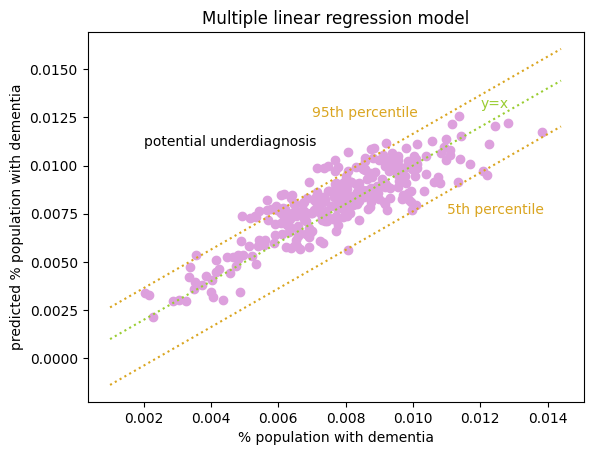

In [43]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# residuals 
all_var_residuals = true_val-y_pred_all

# 5th and 95th perctile of the residuals 
ci_5, ci_95 = np.abs(st.norm.interval(confidence=0.95, 
                 loc=np.mean(all_var_residuals), 
                 scale=np.std(all_var_residuals)))

x_vals = np.arange(0.001, 0.0145, 0.0001)

plt.plot(x_vals, x_vals, ':', color='yellowgreen') # y=x line 
plt.plot(x_vals, x_vals-ci_5, ':', color='goldenrod')
plt.plot(x_vals, x_vals+ci_95, ':', color='goldenrod')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.011, 0.0075, r'5th percentile', fontsize=10, color='goldenrod')
plt.text(0.007, 0.0125, r'95th percentile', fontsize=10, color='goldenrod')
plt.text(0.002, 0.011, r'potential underdiagnosis', fontsize=10)
plt.show()

In [45]:
# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[-all_var_residuals>ci_95]['area_name']
[x for x in list(resid_gap_area)]

['Telford and Wrekin',
 'South Somerset',
 'Medway',
 'South Hams',
 'Knowsley',
 'Isles of Scilly',
 'Worcester',
 'Swale',
 'Redditch',
 'Wychavon',
 'East Cambridgeshire',
 'Tamworth',
 'Swindon',
 "King's Lynn and West Norfolk",
 'Ealing',
 'Scarborough',
 'Somerset West and Taunton',
 'Sandwell',
 'Broxbourne',
 'South Norfolk',
 'North Lincolnshire',
 'Basildon',
 'South Cambridgeshire',
 'Eden',
 'Havering',
 'Thanet',
 'Fenland',
 'Torridge',
 'Plymouth',
 'Nuneaton and Bedworth']

In [24]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
12,E06000013,North Lincolnshire,17200.38,120,22.096,115,0.1089,81,0.2043,104,30774.98,87
25,E06000026,Plymouth,19859.59,72,26.619,64,0.1739,50,0.3060,56,31468.47,63
27,E06000030,Swindon,14382.53,171,18.622,157,0.0909,86,0.1566,134,30560.08,93
32,E06000035,Medway,18587.91,98,23.936,93,0.0859,93,0.2389,86,30780.98,86
49,E06000053,Isles of Scilly,10680.00,245,12.005,258,0.0000,195,0.0000,295,10680.00,317
62,E07000010,Fenland,20893.92,51,25.426,80,0.0727,103,0.2146,96,29790.92,115
69,E07000030,Eden,14688.07,169,16.328,186,0.0000,195,0.0046,280,22163.56,262
83,E07000044,South Hams,12057.07,219,13.724,229,0.0000,195,0.0012,289,20908.71,276
92,E07000066,Basildon,17744.60,111,23.243,100,0.1091,80,0.2623,76,30503.62,94
135,E07000113,Swale,19995.99,69,27.076,56,0.1882,45,0.2555,81,32209.61,29


What happens if I include all possible covariates?

In [25]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

In [26]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.0025377274071593584
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016222644691388975 

female_pc:0.006458668934371678 

ALevel_plus_pc:-0.006027849410573262 

white_pc:-0.004512537715695548 

HYP_afflicted_pc:0.010121593294667754 

DM_afflicted_pc:-0.024289787722671315 

STIA_afflicted_pc:0.23589687853973476 



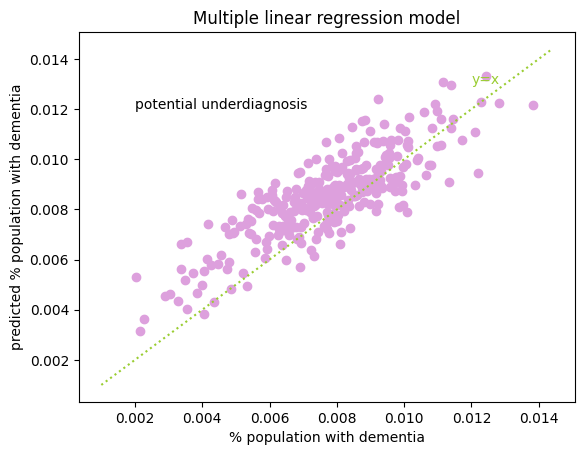

In [27]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [28]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.0025377274071593584
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016222644691388975 

female_pc:0.006458668934371678 

ALevel_plus_pc:-0.006027849410573262 

white_pc:-0.004512537715695548 

HYP_afflicted_pc:0.010121593294667754 

DM_afflicted_pc:-0.024289787722671315 

STIA_afflicted_pc:0.23589687853973476 



NOTE: need to look into DM_afflicted as seems to have a negative correlation - but analysis of just dementia and diabetes found a positive correlation? 

In [29]:
# residuals 
all_var_residuals = y_pred_all-true_val

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[all_var_residuals>0.003]['area_name']
[x for x in list(resid_gap_area)]

['Barking and Dagenham',
 'Slough',
 'Redditch',
 'Ealing',
 'Sandwell',
 'Eden',
 'Newham',
 'Torridge']

In [30]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
36,E06000039,Slough,19788.26,73,22.965,103,0.0000,195,0.1122,152,27534.97,172
69,E07000030,Eden,14688.07,169,16.328,186,0.0000,195,0.0046,280,22163.56,262
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
237,E07000236,Redditch,17343.30,118,22.524,107,0.0909,86,0.2596,80,30212.17,104
274,E08000028,Sandwell,25276.49,8,34.884,12,0.1989,44,0.5349,10,31705.52,53
285,E09000002,Barking and Dagenham,25551.85,5,32.768,21,0.0364,139,0.4724,20,29391.87,125
292,E09000009,Ealing,18991.69,88,22.710,105,0.0204,163,0.1630,127,28827.66,143
308,E09000025,Newham,24138.70,12,29.577,43,0.0244,154,0.2884,67,28987.07,137


In [31]:
df_dem_plus['residual'] = all_var_residuals

In [32]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [33]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [34]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,0.000019,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,-0.000483,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,-0.001020,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,-0.001811,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,0.001525,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,0.631,0.008084,0.565297,0.232554,0.676405,0.132918,0.056508,0.016021,0.000093,224
299,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,0.929,0.007936,0.411796,0.247559,0.617093,0.173991,0.068221,0.023566,0.001592,33
300,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,0.912,0.007503,0.559917,0.270614,0.649017,0.152340,0.057917,0.020497,0.001097,183
301,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,0.858,0.009808,0.587487,0.289789,0.622941,0.148191,0.047888,0.020728,-0.000732,294


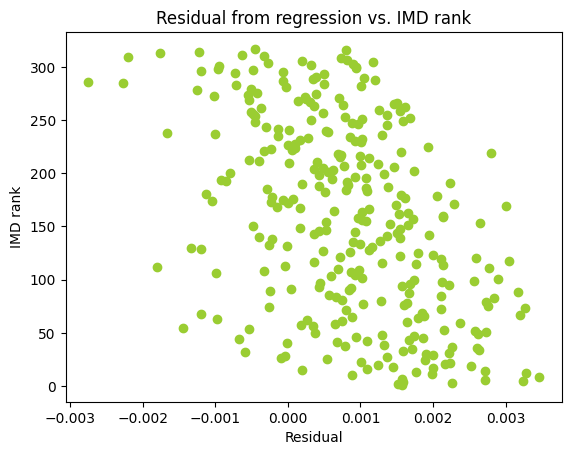

In [35]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

In [36]:
len(df_dem_plus)

306

### Ridge regression 

In [37]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

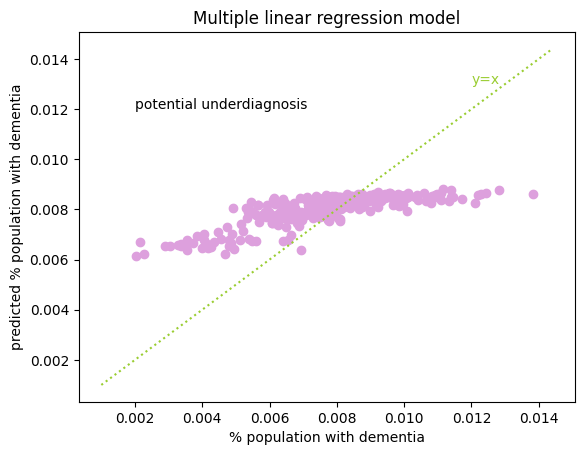

In [38]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [39]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.006187424386378025
-------- 
 coefficients of independent variables 
 
over_65_pc:0.0013339442466762167 

female_pc:-0.0001364181092114162 

ALevel_plus_pc:-0.0010366116361338567 

white_pc:0.0025570201321323204 

HYP_afflicted_pc:0.0007047860541649498 

DM_afflicted_pc:0.00016209130829061095 

STIA_afflicted_pc:0.00013738918231048167 



### Lasso regression 

In [40]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

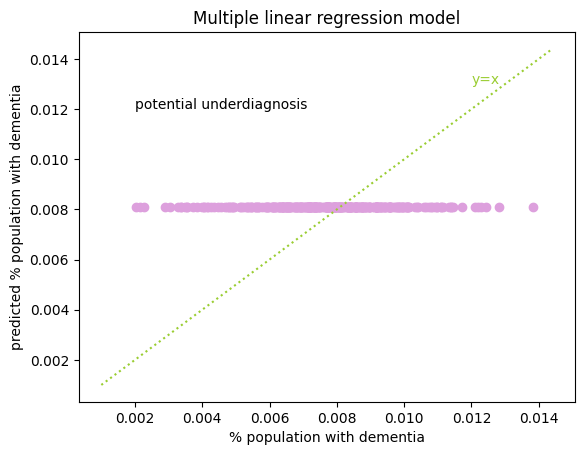

In [41]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0.001, 0.0145, 0.0001), np.arange(0.001, 0.0145, 0.0001), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.012, 0.013, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.002, 0.012, r'potential underdiagnosis', fontsize=10)
plt.show()

In [42]:
regr.coef_[0]

0.0

In [43]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.008088468442761352
-------- 
 coefficients of independent variables 
 
over_65_pc:0.0 

female_pc:-0.0 

ALevel_plus_pc:-0.0 

white_pc:0.0 

HYP_afflicted_pc:0.0 

DM_afflicted_pc:0.0 

STIA_afflicted_pc:0.0 

